## Sprint 11 - Proyecto 11 "Productos alimenticios"

1. INTRODUCCIÓN

Trabajas en una empresa emergente que vende productos alimenticios. Debes investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudia el embudo de ventas. Descubre cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observa los resultados de un test A/A/B (sigue leyendo para obtener más información sobre los test A/A/B). Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control obtienen las fuentes antiguas y un grupo de prueba obtiene las nuevas. Descubre qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas. Podemos establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto puede ayudarnos a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Vamos a utilizar el mismo dataset para el análisis general y para el análisis A/A/B. En proyectos reales, los experimentos se llevan a cabo constantemente. El equipo de análisis estudia la calidad de una aplicación utilizando datos generales, sin prestar atención a si los usuarios participan en experimentos.

2. DESCRIPCIÓN DE LOS DATOS 

Cada entrada de registro es una acción de usuario o un evento.

*/datasets/logs_exp_us.csv*

- EventName: nombre del evento.
- DeviceIDHash: identificador de usuario unívoco.
- EventTimestamp: hora del evento.
- ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

3. INCIALIZACIÓN 

In [1]:
# Se cargan todas las librerias necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import math as mth
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Se cargan los archivos de datos en DataFrame
logs_df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

In [3]:
# Se imprime la informacióin general/resumida de las entradas de registro
logs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
# Se imprime una muestra de las las entradas de registro 
logs_df.head(15)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


3.1 PREPARACIÓN DE LOS DATOS 

In [5]:
# Confirmamos que los tipos de datos en el dataframe 
print(logs_df.dtypes)

EventName         object
DeviceIDHash       int64
EventTimestamp     int64
ExpId              int64
dtype: object


In [6]:
# Renombramos nombre de columnas 
logs_df.columns = ['event_name', 'user_id', 'event_time', 'exp_id']
print(logs_df.columns)

Index(['event_name', 'user_id', 'event_time', 'exp_id'], dtype='object')


In [7]:
# Convertimos "timestamp" a formato datetime
logs_df['event_time'] = pd.to_datetime(logs_df['event_time'], unit='s')

In [8]:
# Confirmamos si existen valores ausentes en el DataFrame 
print("\nValores nulos por columna:")
print(logs_df.isna().sum())


Valores nulos por columna:
event_name    0
user_id       0
event_time    0
exp_id        0
dtype: int64


In [9]:
# Creamos columna para la fecha 
logs_df['event_date'] = logs_df['event_time'].dt.date

In [10]:
# Confirmamos si existen valores duplicados 
duplicates_count = logs_df.duplicated().sum()
print(f"\nDuplicados encontrados: {duplicates_count}")
logs_df = logs_df.drop_duplicates()


Duplicados encontrados: 413


In [11]:
# Ordenamos los eventos por usuarios y tiempo 
logs_df = logs_df.sort_values(by=['user_id', 'event_time'])

In [12]:
# Confirmamos cambios hechos en el Dataframe 
print("\nInfo final del DataFrame:")
print(logs_df.info())
logs_df.head(10)


Info final del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 197263 to 221438
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   exp_id      243713 non-null  int64         
 4   event_date  243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB
None


,event_name,user_id,event_time,exp_id,event_date
197263,MainScreenAppear,6888746892508752,2019-08-06 14:06:34,246,2019-08-06
209196,MainScreenAppear,6909561520679493,2019-08-06 18:52:54,247,2019-08-06
209199,PaymentScreenSuccessful,6909561520679493,2019-08-06 18:52:58,247,2019-08-06
209200,CartScreenAppear,6909561520679493,2019-08-06 18:52:58,247,2019-08-06
209201,MainScreenAppear,6909561520679493,2019-08-06 18:52:58,247,2019-08-06
209210,OffersScreenAppear,6909561520679493,2019-08-06 18:53:04,247,2019-08-06
127670,MainScreenAppear,6922444491712477,2019-08-04 14:19:33,246,2019-08-04
127672,PaymentScreenSuccessful,6922444491712477,2019-08-04 14:19:40,246,2019-08-04
127673,CartScreenAppear,6922444491712477,2019-08-04 14:19:40,246,2019-08-04
127674,MainScreenAppear,6922444491712477,2019-08-04 14:19:40,246,2019-08-04


4. ESTUDIAR Y COMPROBAR LOS DATOS

In [13]:
# ¿Cuántos eventos hay en los registros?
total_eventos = logs_df.shape[0]
print(f"Total de eventos: {total_eventos}")

Total de eventos: 243713


In [14]:
# Conteo por tipo de evento 
print(logs_df['event_name'].value_counts())

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64


In [15]:
# ¿Cuántos usuarios hay en los registros?
unique_users = logs_df['user_id'].nunique()
print(f"Total de usuarios únicos: {unique_users}")

Total de usuarios únicos: 7551


In [16]:
# ¿Cuál es el promedio de eventos por usuario?
avarage_events_user = logs_df.shape[0] / unique_users
print(f"Promedio de eventos por usuario: {avarage_events_user:.2f}")

Promedio de eventos por usuario: 32.28


In [17]:
# ¿Qué periodo de tiempo cubren los datos?
# Localizamos fecha mínima y máxima del dataset
date_min = logs_df['event_time'].min()
date_max = logs_df['event_time'].max()

print(f"Fecha mínima: {date_min}")
print(f"Fecha máxima: {date_max}")

Fecha mínima: 2019-07-25 04:43:36
Fecha máxima: 2019-08-07 21:15:17


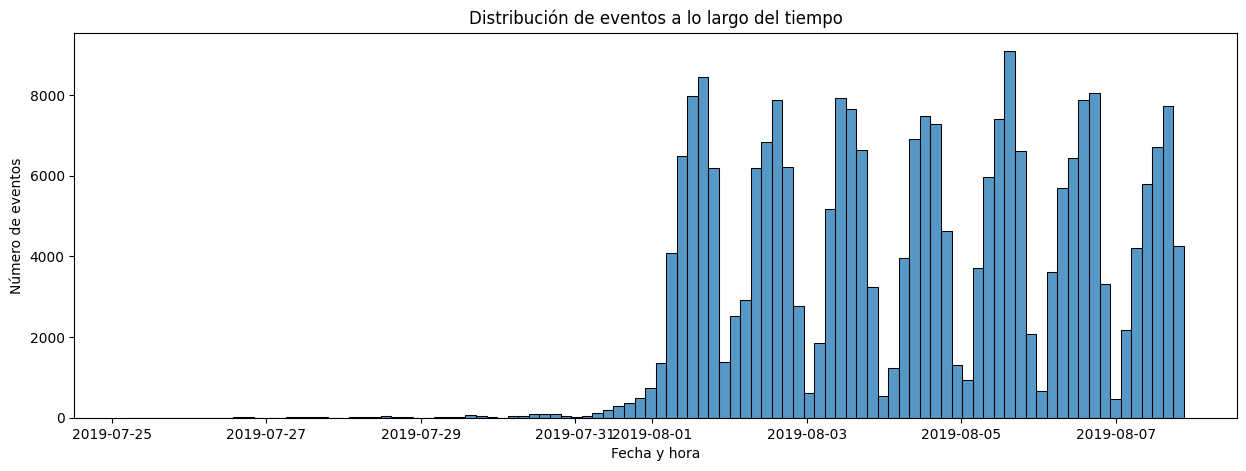

In [18]:
plt.figure(figsize=(15,5))
sns.histplot(logs_df['event_time'], bins=100, kde=False)
plt.title('Distribución de eventos a lo largo del tiempo')
plt.xlabel('Fecha y hora')
plt.ylabel('Número de eventos')
plt.show()

Podemnos observar que las entradas empiezan a tener un aumento significativo a partir de Agosto, talvez podamos ignorar los datos de julio. 

In [19]:
start_date = pd.to_datetime('2019-08-01')

logs_df_filtered = logs_df[logs_df['event_time'] >= start_date].copy()
print(f"Datos filtrados desde {start_date.date()}:")
print(logs_df_filtered.info())

Datos filtrados desde 2019-08-01:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 197263 to 221438
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   user_id     240887 non-null  int64         
 2   event_time  240887 non-null  datetime64[ns]
 3   exp_id      240887 non-null  int64         
 4   event_date  240887 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.0+ MB
None


A partir del 2019-08-01 se ve un volumen estable de eventos diarios
Despues de hacer una filtración de los datos nos quedamos con 240887 eventos dentro del rango. 
Vamos a usar el periodo del experimento y del embudo del 1 de Agosto al 7 de Agosto de 2019 para evitar sesgos por datos incompletos. 

In [20]:
# ¿Perdimos muchos eventos y usuarios al excluir los datos más antiguos?
events_before = logs_df.shape[0]
users_before = logs_df['user_id'].nunique()

events_after = logs_df_filtered.shape[0]
users_after = logs_df_filtered['user_id'].nunique()

print(f"Eventos antes: {events_before}")
print(f"Eventos después: {events_after}")
print(f"Pérdida de eventos: {events_before - events_after} ({(events_before - events_after) / events_before:.2%})")

print(f"Usuarios antes: {users_before}")
print(f"Usuarios después: {users_after}")
print(f"Pérdida de usuarios: {users_before - users_after} ({(users_before - users_after) / users_before:.2%})")

Eventos antes: 243713
Eventos después: 240887
Pérdida de eventos: 2826 (1.16%)
Usuarios antes: 7551
Usuarios después: 7534
Pérdida de usuarios: 17 (0.23%)


En los eventos solo perdimos 1.16% al filtrar los datos antiguos lo cual significa una perdida mínima y son buenas noticias para nuestro análisis porque casi toda la información sigue disponible. 

Y en cuanto a los usuarios solo perdimos 0.23%.

Significa que el filtro temporal que vamos a aplicar no distorsionara mucho el análisis y aún tenemos suficiente representacion en los grupos experimentales. 

In [21]:
# Confirmamos de tener usuarios de los tres grupos experimentales.
print("Usuarios por grupo antes del filtrado:")
print(logs_df.groupby('exp_id')['user_id'].nunique())

print("\nUsuarios por grupo después del filtrado:")
print(logs_df_filtered.groupby('exp_id')['user_id'].nunique())

Usuarios por grupo antes del filtrado:
exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

Usuarios por grupo después del filtrado:
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


Nos muestra una proporción casi uniforme en los tres grupos experimentales lo cual nos indica que el filtrado por fecha no sesgo la proporción

5. ESTUDIAR EL EMBUDO DE EVENTOS

In [22]:
# Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
event_count = logs_df_filtered['event_name'].value_counts().reset_index()
event_count.columns = ['event_name', 'count']

print(event_count)

                event_name   count
0         MainScreenAppear  117328
1       OffersScreenAppear   46333
2         CartScreenAppear   42303
3  PaymentScreenSuccessful   33918
4                 Tutorial    1005


In [23]:
# Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. 
# Ordena los eventos por el número de usuarios. 
# Calcula la proporción de usuarios que realizaron la acción al menos una vez.

users_per_event = (
    logs_df_filtered.groupby('event_name')['user_id']
    .nunique()
    .reset_index(name='user_count')
    .sort_values(by='user_count', ascending=False)
)

total_users = logs_df_filtered['user_id'].nunique()
users_per_event['proportion'] = users_per_event['user_count'] / total_users

print(users_per_event)

                event_name  user_count  proportion
1         MainScreenAppear        7419    0.984736
2       OffersScreenAppear        4593    0.609636
0         CartScreenAppear        3734    0.495620
3  PaymentScreenSuccessful        3539    0.469737
4                 Tutorial         840    0.111495


MainScreenAppear (98.47%)
Casi todos los usuarios (casi el 100%) llegan a la pantalla principal, por eso la proporción es casi 1 (o 100%).

OffersScreenAppear (60.96%)
Aquí, un 61% de usuarios que entraron a la app llegaron a ver las ofertas, la caída es evidente. 

La diferencia (98.47% - 60.96% = 37.51%) es la tasa de abandono entre pantalla principal y ofertas. Es decir, alrededor de 38% de usuarios no avanzan a ver ofertas.

CartScreenAppear (49.56%)
El 49.56% de todos los usuarios llegaron a la pantalla del carrito.
Comparado con el paso anterior (60.96%), la caída es menor:

60.96% - 49.56% = 11.4% de usuarios que vieron ofertas no llegaron al carrito.

PaymentScreenSuccessful (46.97%)
El 46.97% de todos los usuarios completaron un pago exitoso.

49.56% - 46.97% = 2.59% de usuarios que pusieron productos en carrito finalmente no completaron la compra.

Tutorial (11.15%)
Solo el 11% de usuarios vieron el tutorial, lo que sugiere que es una experiencia opcional o solo para nuevos usuarios.

In [24]:
# ¿En qué orden crees que ocurrieron las acciones? 
# ¿Todas son parte de una sola secuencia? 
# No es necesario tenerlas en cuenta al calcular el embudo.

Basándonos en los nombres y sentido común, este sería el orden más lógico:

- MainScreenAppear: la pantalla principal aparece primero, es el punto de entrada.

- OffersScreenAppear: luego el usuario puede navegar a la sección de ofertas.

- CartScreenAppear: tras ver ofertas o seleccionar productos, aparece la pantalla del carrito.

- PaymentScreenSuccessful: finalmente, cuando el usuario completa la compra exitosamente.

- Tutorial: podría mostrarse en cualquier momento, probablemente solo al inicio o para usuarios nuevos, no necesariamente parte del flujo principal.

Para calcular el embudo vamos a considerar los eventos que forman parte de la "cadena lógica" del proceso de compra, vamos a excluir eventos secundarios como "Tutorial" ya que puede ocurrir en distintos momentos o no suceder en la misma sesión. 

In [25]:
# Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. 
# Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

# Calculamos la cantidad de usuarios únicos por cada evento 
unique_users_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Usuarios únicos por evento en orden
user_counts = logs_df_filtered[logs_df_filtered['event_name'].isin(unique_users_events)] \
    .groupby('event_name')['user_id'].nunique() \
    .reindex(unique_users_events)

print(user_counts)

print()

# Calculamos la proporción de usuarios que pasan de una etapa a otra 
transition_stages = user_counts.shift(-1) / user_counts

# Quitamos el último NaN porque no hay siguiente paso
transition_stages = transition_stages[:-1]

for i in range(len(transition_stages)):
    present_stage = unique_users_events[i]
    next_stage = unique_users_events[i+1]
    proporcion = transition_stages.iloc[i]
    print(f"Proporción de usuarios que pasan de {present_stage} a {next_stage}: {proporcion:.2%}")


event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Name: user_id, dtype: int64

Proporción de usuarios que pasan de MainScreenAppear a OffersScreenAppear: 61.91%
Proporción de usuarios que pasan de OffersScreenAppear a CartScreenAppear: 81.30%
Proporción de usuarios que pasan de CartScreenAppear a PaymentScreenSuccessful: 94.78%


In [26]:
# ¿En qué etapa pierdes más usuarios?

La mayor perdida de los usuarios ocurre entre MainScreenAppear y OffersScreenAppear, porque solo el 61.91% de los usuarios que se encuentran en la pantalla princiapl avanzan a la pantalla de ofertas. 

In [27]:
# ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

Lo más simple y común es medir qué porcentaje de usuarios totales completaron el pago exitoso ya que casi todo los usuarios empiezan en la página principal. 
Sabemos que 7534 es nuestro total de usuarios después de filtrar los datos con el periodo 1 de Agosto al 7 de Agosto de 2019 
Tambien sabemos que 3539 son los usuarios que completaron su pago. 

Entonces, el porcentaje de usuarios que completaron todo el viaje (al menos llegaron a la compra) es:

3539 / 7534 x 100 = 46.97%

Podemos confirmar que casi el 47% de los usuarios detro del periodo establecido hace todo el viaje desde la pagina principal hasta completar la compra.

6. ESTUDIAR LOS RESULTADOS DEL EXPERIMENTO

In [28]:
# ¿Cuántos usuarios hay en cada grupo?

print("Usuarios por grupo antes del filtrado:")
print(logs_df.groupby('exp_id')['user_id'].nunique())

print("\nUsuarios por grupo después del filtrado:")
print(logs_df_filtered.groupby('exp_id')['user_id'].nunique())

Usuarios por grupo antes del filtrado:
exp_id
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

Usuarios por grupo después del filtrado:
exp_id
246    2484
247    2513
248    2537
Name: user_id, dtype: int64


In [29]:
# Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos.
# Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

# Filtramos usuarios únicos por grupo
groups = [246, 247]

# Número de usuarios únicos en cada grupo
users_group = logs_df_filtered[logs_df_filtered['exp_id'].isin(groups)].groupby('exp_id')['user_id'].nunique()

# Número de usuarios que completaron pago en cada grupo
payment_users_group = logs_df_filtered[
    (logs_df_filtered['exp_id'].isin(groups)) & (logs_df_filtered['event_name'] == 'PaymentScreenSuccessful')
].groupby('exp_id')['user_id'].nunique()

counts = payment_users_group.values
nobs = users_group.values

stat, pval = proportions_ztest(count=counts, nobs=nobs)

print(f'Estadístico Z: {stat:.4f}')
print(f'Valor p: {pval:.4f}')

if pval < 0.05:
    print("Hay diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("No hay diferencia estadísticamente significativa entre los grupos 246 y 247.")

Estadístico Z: 1.5780
Valor p: 0.1146
No hay diferencia estadísticamente significativa entre los grupos 246 y 247.


In [30]:
# Selecciona el evento más popular. 
# En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. 
# Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. 
# Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). 
# ¿Puedes confirmar que los grupos se dividieron correctamente?

In [31]:
def test_event_proportion(df, group1, group2, event):
    total_users = df[df['exp_id'].isin([group1, group2])].groupby('exp_id')['user_id'].nunique()
    
    event_users = df[(df['exp_id'].isin([group1, group2])) & (df['event_name'] == event)] \
        .groupby('exp_id')['user_id'].nunique()
    
    event_users = event_users.reindex([group1, group2], fill_value=0)
    total_users = total_users.reindex([group1, group2], fill_value=0)
    
    counts = event_users.values
    nobs = total_users.values
    
    stat, pval = proportions_ztest(count=counts, nobs=nobs)
    
    print(f"Evento: {event}")
    print(f"Grupo {group1}: {counts[0]} usuarios / {nobs[0]} totales -> {counts[0]/nobs[0]:.2%}")
    print(f"Grupo {group2}: {counts[1]} usuarios / {nobs[1]} totales -> {counts[1]/nobs[1]:.2%}")
    print(f"Estadístico Z: {stat:.4f}")
    print(f"Valor p: {pval:.4f}")
    
    if pval < 0.05:
        print("Diferencia estadísticamente significativa\n")
    else:
        print("No hay diferencia estadísticamente significativa\n")

events = logs_df_filtered['event_name'].unique()

for event in events:
    test_event_proportion(logs_df_filtered, 246, 247, event)

Evento: MainScreenAppear
Grupo 246: 2450 usuarios / 2484 totales -> 98.63%
Grupo 247: 2476 usuarios / 2513 totales -> 98.53%
Estadístico Z: 0.3093
Valor p: 0.7571
No hay diferencia estadísticamente significativa

Evento: PaymentScreenSuccessful
Grupo 246: 1200 usuarios / 2484 totales -> 48.31%
Grupo 247: 1158 usuarios / 2513 totales -> 46.08%
Estadístico Z: 1.5780
Valor p: 0.1146
No hay diferencia estadísticamente significativa

Evento: CartScreenAppear
Grupo 246: 1266 usuarios / 2484 totales -> 50.97%
Grupo 247: 1238 usuarios / 2513 totales -> 49.26%
Estadístico Z: 1.2034
Valor p: 0.2288
No hay diferencia estadísticamente significativa

Evento: OffersScreenAppear
Grupo 246: 1542 usuarios / 2484 totales -> 62.08%
Grupo 247: 1520 usuarios / 2513 totales -> 60.49%
Estadístico Z: 1.1550
Valor p: 0.2481
No hay diferencia estadísticamente significativa

Evento: Tutorial
Grupo 246: 278 usuarios / 2484 totales -> 11.19%
Grupo 247: 283 usuarios / 2513 totales -> 11.26%
Estadístico Z: -0.0782
V

Podemos confirmar que en los eventos relevantes no hay diferencias estadisticamente significativas entre los grupos 246 y 247, significa que la división de usuarios fue correcta y uniforme.

In [32]:
# Haz lo mismo para el grupo con fuentes alteradas. 
# Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. 
# Compara los resultados con los resultados combinados de los grupos de control. 
# ¿Qué conclusiones puedes sacar del experimento?

In [33]:
def test_event_proportion(df, group1, group2, event):
    total_users = df[df['exp_id'].isin([group1, group2])].groupby('exp_id')['user_id'].nunique()
    event_users = df[(df['exp_id'].isin([group1, group2])) & (df['event_name'] == event)] \
        .groupby('exp_id')['user_id'].nunique()
    
    event_users = event_users.reindex([group1, group2], fill_value=0)
    total_users = total_users.reindex([group1, group2], fill_value=0)
    
    counts = event_users.values
    nobs = total_users.values
    
    stat, pval = proportions_ztest(count=counts, nobs=nobs)
    
    print(f"Evento: {event}")
    print(f"Grupo {group1}: {counts[0]} usuarios / {nobs[0]} totales -> {counts[0]/nobs[0]:.2%}")
    print(f"Grupo {group2}: {counts[1]} usuarios / {nobs[1]} totales -> {counts[1]/nobs[1]:.2%}")
    print(f"Estadístico Z: {stat:.4f}")
    print(f"Valor p: {pval:.4f}")
    if pval < 0.05:
        print("Diferencia estadísticamente significativa\n")
    else:
        print("No hay diferencia estadísticamente significativa\n")

events = logs_df_filtered['event_name'].unique()

print("Comparación grupo 248 vs grupo 246")
for event in events:
    test_event_proportion(logs_df_filtered, 248, 246, event)

print("\nComparación grupo 248 vs grupo 247")
for event in events:
    test_event_proportion(logs_df_filtered, 248, 247, event)

control_df = logs_df_filtered[logs_df_filtered['exp_id'].isin([246, 247])].copy()
control_df['exp_id'] = 0  # Nuevo id para grupo combinado control

test_df = logs_df_filtered[logs_df_filtered['exp_id'] == 248].copy()

combined_df = pd.concat([control_df, test_df])

print("Comparación grupo 248 vs grupos control combinados (0)")

for event in events:
    test_event_proportion(combined_df, 0, 248, event)

Comparación grupo 248 vs grupo 246
Evento: MainScreenAppear
Grupo 248: 2493 usuarios / 2537 totales -> 98.27%
Grupo 246: 2450 usuarios / 2484 totales -> 98.63%
Estadístico Z: -1.0473
Valor p: 0.2950
No hay diferencia estadísticamente significativa

Evento: PaymentScreenSuccessful
Grupo 248: 1181 usuarios / 2537 totales -> 46.55%
Grupo 246: 1200 usuarios / 2484 totales -> 48.31%
Estadístico Z: -1.2474
Valor p: 0.2123
No hay diferencia estadísticamente significativa

Evento: CartScreenAppear
Grupo 248: 1230 usuarios / 2537 totales -> 48.48%
Grupo 246: 1266 usuarios / 2484 totales -> 50.97%
Estadístico Z: -1.7599
Valor p: 0.0784
No hay diferencia estadísticamente significativa

Evento: OffersScreenAppear
Grupo 248: 1531 usuarios / 2537 totales -> 60.35%
Grupo 246: 1542 usuarios / 2484 totales -> 62.08%
Estadístico Z: -1.2581
Valor p: 0.2084
No hay diferencia estadísticamente significativa

Evento: Tutorial
Grupo 248: 279 usuarios / 2537 totales -> 11.00%
Grupo 246: 278 usuarios / 2484 tot

Los resultados muestran que no hay diferencias estadísticamente significativas en la proporción de usuarios que realizan cada evento entre el grupo con fuentes alteradas (248) y:

- Cada uno de los grupos de control (246 y 247) por separado

Significa que el cambio de fuentes no afectó el comportamiento de los usuarios en términos de las acciones clave dentro de la aplicación.

No hubo impacto negativo ni positivo relevante detectable en las métricas

In [34]:
# ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? 
# Calcula cuántas pruebas de hipótesis estadísticas has realizado. 
# Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. 
# ¿Cuál debería ser el nivel de significancia? 
# Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

α=0.05 (5% - común en estadística)

Esto significa que hay un 5% de probabilidad de cometer un error tipo I (rechazar la hipótesis nula cuando es cierta).

Comparamos cada uno de los 5 eventos

Contra cada par de grupos:

246 vs 247 = 5 pruebas

248 vs 246 = 5 pruebas

248 vs 247 = 5 pruebas

248 vs controles combinados = 5 pruebas

5×4=20 pruebas estadísticas.

Con 20 pruebas y 𝛼=0.05, en promedio 1 de cada 20 pruebas puede dar un falso positivo.

Como realizamos 20 pruebas, la probabilidad de obtener al menos un falso positivo aumenta, porque cada prueba puede fallar independientemente, podemos usar la Corrección de Bonferroni
α=0.05 / Número de pruebas (20) = 0.0025

In [35]:
if pval < 0.0025:  
    print("Diferencia estadísticamente significativa\n")
else:
    print("No hay diferencia estadísticamente significativa\n")

No hay diferencia estadísticamente significativa

